<a href="https://colab.research.google.com/github/deepeshacharya/Banking-Index-Analysis/blob/main/Agent_Based_Model_of_NFS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Basic Liabraries**

In [ ]:
!pip install numpy pandas mesa

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 3.2 MB/s eta 0:00:00


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving ABM.csv to ABM (5).csv


**Preview The Data**

We have imported the data from merolagani.com. During trading pumpers first buys the stocks from the market during bull which covers certain percent of overall stocks and then when due to political gesture the market rise up those pumpers make a charm in the market to buy sometimes themselves, somtimes spreading emotions in the news and sometimes. This creates rise in the price. We have the data of Feb 2024 to Feb 20 2025 to analyze

In [ ]:
import numpy as np
import pandas as pd
import mesa
file_path = 'ABM.csv'
df = pd.read_csv(file_path)

print(df.head())

   SN Unnamed: 1      Date  Buyer  Seller Qty.   Rate  Amount
0   1        NaN  2/1/2024     33      46  365  338.0  123370
1   2        NaN  2/1/2024     39      46  135  338.0   45630
2   3        NaN  2/1/2024     39      36  200  338.0   67600
3   4        NaN  2/1/2024     39      57  165  338.0   55770
4   5        NaN  2/1/2024     49      57   10  338.0    3380


**Built Graph**

In the capital market espacially in the trading stock I have mentioned 'Manupulators' and 'Non- Manupulators' both have their nodes 'Trading Capacity which covers volume' and Edges'Transactions'which participate iteratively in the market.



In [ ]:

def build_graph(df):
    """
    Build a directed graph representation from the entire dataset.
    Returns:
        node_features_dict: { broker_id: [buy_vol, sell_vol, net_vol, avg_rate, total_trades, volatility, is_manipulator] }
        edge_dict: { (buyer, seller): { 'qty_sum': ..., 'count': ..., 'avg_rate': ... } }
    """
    nodes = {}
    edges = {}

    # Ensure that the quantity and rate columns are numeric
    df['Qty.'] = pd.to_numeric(df['Qty.'], errors='coerce')
    df['Rate'] = pd.to_numeric(df['Rate'], errors='coerce')

    # Define manipulators
    manipulators = ['Manipulator1', 'Manipulator2', 'Manipulator3']

    for _, row in df.iterrows():
        buyer = row['Buyer']
        seller = row['Seller']
        qty = row['Qty.']
        rate = row['Rate']
        is_manipulator = buyer in manipulators or seller in manipulators

        # Skip rows with NaN values in qty or rate
        if pd.isna(qty) or pd.isna(rate):
            continue

        # Update buyer node
        if buyer not in nodes:
            nodes[buyer] = {
                'buy_vol': 0, 'sell_vol': 0, 'rates': [], 'is_manipulator': buyer in manipulators
            }
        nodes[buyer]['buy_vol'] += qty
        nodes[buyer]['rates'].append(rate)

        # Update seller node
        if seller not in nodes:
            nodes[seller] = {
                'buy_vol': 0, 'sell_vol': 0, 'rates': [], 'is_manipulator': seller in manipulators
            }
        nodes[seller]['sell_vol'] += qty
        nodes[seller]['rates'].append(rate)

        # Update edge (buyer -> seller)
        edge_key = (buyer, seller)
        if edge_key not in edges:
            edges[edge_key] = {
                'qty_sum': 0,  # total shares traded
                'count': 0,    # number of transactions
                'rate_sum': 0, # sum of rates to compute average
            }
        edges[edge_key]['qty_sum'] += qty
        edges[edge_key]['count'] += 1
        edges[edge_key]['rate_sum'] += rate

    # Build node feature dictionary
    node_features_dict = {}
    for broker, info in nodes.items():
        buy_vol = info['buy_vol']
        sell_vol = info['sell_vol']
        net_vol = buy_vol - sell_vol
        avg_rate = np.mean(info['rates']) if info['rates'] else 0
        total_trades = len(info['rates'])  # how many times this broker participated
        volatility = np.std(info['rates']) if len(info['rates']) > 1 else 0
        is_manipulator = info['is_manipulator']

        node_features_dict[broker] = [
            buy_vol,
            sell_vol,
            net_vol,
            avg_rate,
            total_trades,
            volatility,
            is_manipulator
        ]

    # Update edge attributes (like average rate)
    for key, info in edges.items():
        edges[key]['avg_rate'] = info['rate_sum'] / info['count'] if info['count'] > 0 else 0

    return node_features_dict, edges

# Build graph from DataFrame
node_features_dict, edge_dict = build_graph(df)
print(node_features_dict)
print(edge_dict)

{33: [35783.0, 34552.0, 1231.0, np.float64(353.66684636118606), 371, np.float64(10.769451430998844), False], 46: [14780.0, 26813.0, -12033.0, np.float64(354.4244565217391), 184, np.float64(11.63438493209287), False], 39: [24731.0, 19070.0, 5661.0, np.float64(352.8585714285714), 280, np.float64(10.043700838366913), False], 36: [13452.0, 20896.0, -7444.0, np.float64(350.4964102564102), 195, np.float64(12.784423111475467), False], 57: [40765.0, 35897.0, 4868.0, np.float64(353.12459016393444), 488, np.float64(12.013109720630343), False], 49: [46251.0, 42768.0, 3483.0, np.float64(353.25452793834296), 519, np.float64(11.653337846556342), False], 14: [27178.0, 29725.0, -2547.0, np.float64(350.49078498293517), 293, np.float64(10.98971985026073), False], 71: [61818.0, 71932.0, -10114.0, np.float64(351.9873333333333), 450, np.float64(8.640429233165058), False], 34: [58077.0, 46959.0, 11118.0, np.float64(353.5654761904762), 504, np.float64(11.557226428073067), False], 25: [35224.0, 26244.0, 8980.

**Agent Design (Mesa Simulation Desion)**


As mentioned about the nodes and edges defined above, we have made the two groups of players here. One is manupulators and other are general public. Its a logic and design to for the simulation.

In [ ]:

from mesa import Agent

class ManipulatorAgent(Agent):
    """ An agent representing a manipulator in the market. """
    def __init__(self, unique_id, model, features):
        super().__init__(unique_id, model)
        self.features = features
        self.buy_vol = features[0]
        self.sell_vol = features[1]
        self.net_vol = features[2]
        self.avg_rate = features[3]
        self.total_trades = features[4]
        self.volatility = features[5]
        self.is_manipulator = features[6]

    def step(self):
        # Manipulator behavior to pump and dump prices
        pass

class PublicTraderAgent(Agent):
    """ An agent representing a public trader in the market. """
    def __init__(self, unique_id, model, features):
        super().__init__(unique_id, model)
        self.features = features
        self.buy_vol = features[0]
        self.sell_vol = features[1]
        self.net_vol = features[2]
        self.avg_rate = features[3]
        self.total_trades = features[4]
        self.volatility = features[5]
        self.is_manipulator = features[6]

    def step(self):
        # Public trader behavior to follow manipulators
        pass

In [ ]:
import numpy as np
import pandas as pd

def build_graph(df):
    """
    Build a directed graph representation from the entire dataset.
    Returns:
        node_features_dict: { broker_id: [buy_vol, sell_vol, net_vol, avg_rate, total_trades, volatility, is_manipulator] }
        edge_dict: { (buyer, seller): { 'qty_sum': ..., 'count': ..., 'avg_rate': ... } }
    """
    nodes = {}
    edges = {}

    # Ensure that the quantity and rate columns are numeric
    df['Qty.'] = pd.to_numeric(df['Qty.'], errors='coerce')
    df['Rate'] = pd.to_numeric(df['Rate'], errors='coerce')

    # Defining manipulators based on updated conditions
    buy_volume_threshold = df['Qty.'].quantile(0.95)  # Top 5% buy volume is considered significant
    sell_volume_threshold = df['Qty.'].quantile(0.05)  # Bottom 5% sell volume is considered significant

    for _, row in df.iterrows():
        buyer = row['Buyer']
        seller = row['Seller']
        qty = row['Qty.']
        rate = row['Rate']

        # Skip rows with NaN values in qty or rate
        if pd.isna(qty) or pd.isna(rate):
            continue

        # Update buyer node
        if buyer not in nodes:
            nodes[buyer] = {
                'buy_vol': 0, 'sell_vol': 0, 'rates': [], 'is_manipulator': False
            }
        nodes[buyer]['buy_vol'] += qty
        nodes[buyer]['rates'].append(rate)

        # Update seller node
        if seller not in nodes:
            nodes[seller] = {
                'buy_vol': 0, 'sell_vol': 0, 'rates': [], 'is_manipulator': False
            }
        nodes[seller]['sell_vol'] += qty
        nodes[seller]['rates'].append(rate)

        # Update edge (buyer -> seller)
        edge_key = (buyer, seller)
        if edge_key not in edges:
            edges[edge_key] = {
                'qty_sum': 0,  # total shares traded
                'count': 0,    # number of transactions
                'rate_sum': 0, # sum of rates to compute average
            }
        edges[edge_key]['qty_sum'] += qty
        edges[edge_key]['count'] += 1
        edges[edge_key]['rate_sum'] += rate

    # Build node feature dictionary
    node_features_dict = {}
    for broker, info in nodes.items():
        buy_vol = info['buy_vol']
        sell_vol = info['sell_vol']
        net_vol = buy_vol - sell_vol
        avg_rate = np.mean(info['rates']) if info['rates'] else 0
        total_trades = len(info['rates'])  # how many times this broker participated
        volatility = np.std(info['rates']) if len(info['rates']) > 1 else 0
        is_manipulator = False

        # Identify manipulators based on the conditions provided
        if buy_vol >= buy_volume_threshold:
            is_manipulator = True
        elif sell_vol <= sell_volume_threshold and sell_vol > 0:
            is_manipulator = True

        node_features_dict[broker] = [
            buy_vol,
            sell_vol,
            net_vol,
            avg_rate,
            total_trades,
            volatility,
            is_manipulator
        ]

    # Update edge attributes (like average rate)
    for key, info in edges.items():
        edges[key]['avg_rate'] = info['rate_sum'] / info['count'] if info['count'] > 0 else 0

    return node_features_dict, edges

# Load data from CSV file
file_path = 'ABM.csv'  # Use the filename directly as it's uploaded to the current directory
df = pd.read_csv(file_path)

# Build graph from DataFrame
node_features_dict, edge_dict = build_graph(df)
print(node_features_dict)
print(edge_dict)

{33: [35783.0, 34552.0, 1231.0, np.float64(353.66684636118606), 371, np.float64(10.769451430998844), True], 46: [14780.0, 26813.0, -12033.0, np.float64(354.4244565217391), 184, np.float64(11.63438493209287), True], 39: [24731.0, 19070.0, 5661.0, np.float64(352.8585714285714), 280, np.float64(10.043700838366913), True], 36: [13452.0, 20896.0, -7444.0, np.float64(350.4964102564102), 195, np.float64(12.784423111475467), True], 57: [40765.0, 35897.0, 4868.0, np.float64(353.12459016393444), 488, np.float64(12.013109720630343), True], 49: [46251.0, 42768.0, 3483.0, np.float64(353.25452793834296), 519, np.float64(11.653337846556342), True], 14: [27178.0, 29725.0, -2547.0, np.float64(350.49078498293517), 293, np.float64(10.98971985026073), True], 71: [61818.0, 71932.0, -10114.0, np.float64(351.9873333333333), 450, np.float64(8.640429233165058), True], 34: [58077.0, 46959.0, 11118.0, np.float64(353.5654761904762), 504, np.float64(11.557226428073067), True], 25: [35224.0, 26244.0, 8980.0, np.flo

In [ ]:
for key in edge_dict.keys():
    print(f"Key: {key}, Types: {[type(item) for item in key]}")

Key: (33, 46), Types: [<class 'int'>, <class 'int'>]
Key: (39, 46), Types: [<class 'int'>, <class 'int'>]
Key: (39, 36), Types: [<class 'int'>, <class 'int'>]
Key: (39, 57), Types: [<class 'int'>, <class 'int'>]
Key: (49, 57), Types: [<class 'int'>, <class 'int'>]
Key: (49, 14), Types: [<class 'int'>, <class 'int'>]
Key: (71, 34), Types: [<class 'int'>, <class 'int'>]
Key: (25, 25), Types: [<class 'int'>, <class 'int'>]
Key: (42, 25), Types: [<class 'int'>, <class 'int'>]
Key: (25, 72), Types: [<class 'int'>, <class 'int'>]
Key: (71, 45), Types: [<class 'int'>, <class 'int'>]
Key: (71, 38), Types: [<class 'int'>, <class 'int'>]
Key: (38, 32), Types: [<class 'int'>, <class 'int'>]
Key: (25, 38), Types: [<class 'int'>, <class 'int'>]
Key: (25, 21), Types: [<class 'int'>, <class 'int'>]
Key: (34, 58), Types: [<class 'int'>, <class 'int'>]
Key: (58, 51), Types: [<class 'int'>, <class 'int'>]
Key: (56, 51), Types: [<class 'int'>, <class 'int'>]
Key: (71, 51), Types: [<class 'int'>, <class '

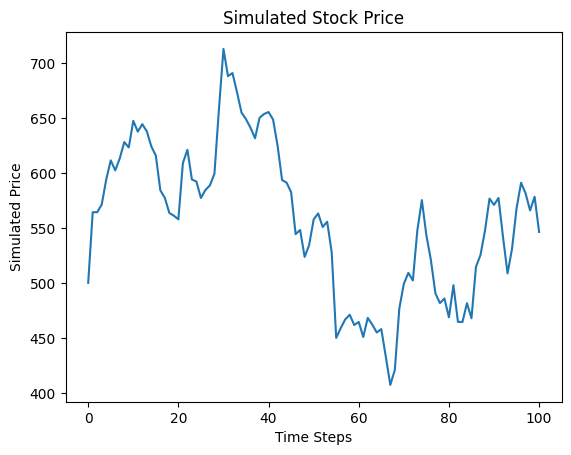

In [ ]:
import random
import matplotlib.pyplot as plt #import here to ensure it is imported.

def build_graph(df):
    """
    Build a directed graph representation from the entire dataset.
    Returns:
        node_features_dict: { broker_id: [buy_vol, sell_vol, net_vol, avg_rate, total_trades, volatility, is_manipulator] }
        edge_dict: { (buyer, seller): { 'qty_sum': ..., 'count': ..., 'avg_rate': ... } }
    """
    nodes = {}
    edges = {}

    # Ensure that the quantity and rate columns are numeric
    df['Qty.'] = pd.to_numeric(df['Qty.'], errors='coerce')
    df['Rate'] = pd.to_numeric(df['Rate'], errors='coerce')

    # Defining manipulators based on updated conditions
    buy_volume_threshold = df['Qty.'].quantile(0.95)  # Top 5% buy volume is considered significant
    sell_volume_threshold = df['Qty.'].quantile(0.05)  # Bottom 5% sell volume is considered significant

    for _, row in df.iterrows():
        buyer = row['Buyer']
        seller = row['Seller']
        qty = row['Qty.']
        rate = row['Rate']

        # Skip rows with NaN values in qty or rate
        if pd.isna(qty) or pd.isna(rate):
            continue

        # Update buyer node
        if buyer not in nodes:
            nodes[buyer] = {
                'buy_vol': 0, 'sell_vol': 0, 'rates': [], 'is_manipulator': False
            }
        nodes[buyer]['buy_vol'] += qty
        nodes[buyer]['rates'].append(rate)

        # Update seller node
        if seller not in nodes:
            nodes[seller] = {
                'buy_vol': 0, 'sell_vol': 0, 'rates': [], 'is_manipulator': False
            }
        nodes[seller]['sell_vol'] += qty
        nodes[seller]['rates'].append(rate)

        # Update edge (buyer -> seller)
        edge_key = (buyer, seller)
        if edge_key not in edges:
            edges[edge_key] = {
                'qty_sum': 0,  # total shares traded
                'count': 0,    # number of transactions
                'rate_sum': 0, # sum of rates to compute average
            }
        edges[edge_key]['qty_sum'] += qty
        edges[edge_key]['count'] += 1
        edges[edge_key]['rate_sum'] += rate

    # Build node feature dictionary
    node_features_dict = {}
    for broker, info in nodes.items():
        buy_vol = info['buy_vol']
        sell_vol = info['sell_vol']
        net_vol = buy_vol - sell_vol
        avg_rate = np.mean(info['rates']) if info['rates'] else 0
        total_trades = len(info['rates'])  # how many times this broker participated
        volatility = np.std(info['rates']) if len(info['rates']) > 1 else 0
        is_manipulator = False

        # Identify manipulators based on the conditions provided
        if buy_vol >= buy_volume_threshold:
            is_manipulator = True
        elif sell_vol <= sell_volume_threshold and sell_vol > 0:
            is_manipulator = True

        node_features_dict[broker] = [
            buy_vol,
            sell_vol,
            net_vol,
            avg_rate,
            total_trades,
            volatility,
            is_manipulator
        ]

    # Update edge attributes (like average rate)
    for key, info in edges.items():
        edges[key]['avg_rate'] = info['rate_sum'] / info['count'] if info['count'] > 0 else 0

    return node_features_dict, edges

def price_simulation(node_features, edge_features, initial_price=500, time_steps=100):
    prices = [initial_price]
    for _ in range(time_steps):
        current_price = prices[-1]
        price_change = 0

        # Simulate price impact of buy/sell volumes
        for broker, features in node_features.items():
            buy_vol, sell_vol, _, avg_rate, _, _, is_manipulator = features
            net_vol = buy_vol - sell_vol
            price_change += net_vol * 0.001 # 0.001 is a sensitivity parameter

            # Simulate impact of manipulators
            if is_manipulator:
                price_change += random.uniform(-5, 5) #Add random price change.

        # Add random noise to simulate market volatility
        price_change += random.uniform(-2, 2)

        new_price = max(1, current_price + price_change) #Ensure price doesn't go negative.
        prices.append(new_price)

    return prices

# Load data from CSV file
file_path = 'ABM.csv'
df = pd.read_csv(file_path)

# Build graph from DataFrame
node_features_dict, edge_dict = build_graph(df)

# Run the simulation
simulated_prices = price_simulation(node_features_dict, edge_dict)

# Plot the simulated prices

plt.plot(simulated_prices)
plt.xlabel('Time Steps')
plt.ylabel('Simulated Price')
plt.title('Simulated Stock Price')
plt.show()

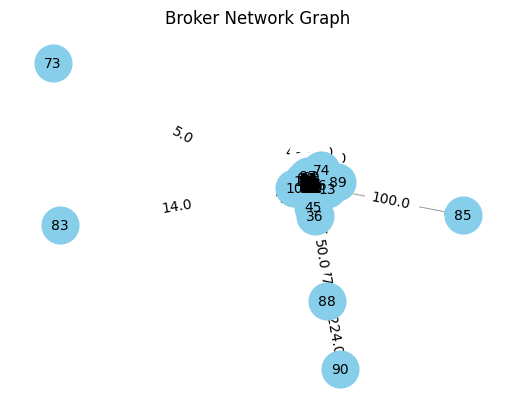

In [ ]:

import matplotlib.pyplot as plt
import networkx as nx


def build_graph(df):
    """
    Build a directed graph representation from the entire dataset.
    Returns:
        node_features_dict: { broker_id: [buy_vol, sell_vol, net_vol, avg_rate, total_trades, volatility, is_manipulator] }
        edge_dict: { (buyer, seller): { 'qty_sum': ..., 'count': ..., 'avg_rate': ... } }
    """
    nodes = {}
    edges = {}

    # Ensure that the quantity and rate columns are numeric
    df['Qty.'] = pd.to_numeric(df['Qty.'], errors='coerce')
    df['Rate'] = pd.to_numeric(df['Rate'], errors='coerce')

    # Defining manipulators based on updated conditions
    buy_volume_threshold = df['Qty.'].quantile(0.95)  # Top 5% buy volume is considered significant
    sell_volume_threshold = df['Qty.'].quantile(0.05)  # Bottom 5% sell volume is considered significant

    for _, row in df.iterrows():
        buyer = row['Buyer']
        seller = row['Seller']
        qty = row['Qty.']
        rate = row['Rate']

        # Skip rows with NaN values in qty or rate
        if pd.isna(qty) or pd.isna(rate):
            continue

        # Update buyer node
        if buyer not in nodes:
            nodes[buyer] = {
                'buy_vol': 0, 'sell_vol': 0, 'rates': [], 'is_manipulator': False
            }
        nodes[buyer]['buy_vol'] += qty
        nodes[buyer]['rates'].append(rate)

        # Update seller node
        if seller not in nodes:
            nodes[seller] = {
                'buy_vol': 0, 'sell_vol': 0, 'rates': [], 'is_manipulator': False
            }
        nodes[seller]['sell_vol'] += qty
        nodes[seller]['rates'].append(rate)

        # Update edge (buyer -> seller)
        edge_key = (buyer, seller)
        if edge_key not in edges:
            edges[edge_key] = {
                'qty_sum': 0,  # total shares traded
                'count': 0,    # number of transactions
                'rate_sum': 0, # sum of rates to compute average
            }
        edges[edge_key]['qty_sum'] += qty
        edges[edge_key]['count'] += 1
        edges[edge_key]['rate_sum'] += rate

    # Build node feature dictionary
    node_features_dict = {}
    for broker, info in nodes.items():
        buy_vol = info['buy_vol']
        sell_vol = info['sell_vol']
        net_vol = buy_vol - sell_vol
        avg_rate = np.mean(info['rates']) if info['rates'] else 0
        total_trades = len(info['rates'])  # how many times this broker participated
        volatility = np.std(info['rates']) if len(info['rates']) > 1 else 0
        is_manipulator = False

        # Identify manipulators based on the conditions provided
        if buy_vol >= buy_volume_threshold:
            is_manipulator = True
        elif sell_vol <= sell_volume_threshold and sell_vol > 0:
            is_manipulator = True

        node_features_dict[broker] = [
            buy_vol,
            sell_vol,
            net_vol,
            avg_rate,
            total_trades,
            volatility,
            is_manipulator
        ]

    # Update edge attributes (like average rate)
    for key, info in edges.items():
        edges[key]['avg_rate'] = info['rate_sum'] / info['count'] if info['count'] > 0 else 0

    return node_features_dict, edges

# Load data from CSV file
file_path = 'ABM.csv'
df = pd.read_csv(file_path)

# Build graph from DataFrame
node_features_dict, edge_dict = build_graph(df)

# Create a directed graph using networkx
G = nx.DiGraph()

# Add nodes and their attributes
for broker, features in node_features_dict.items():
    G.add_node(broker, features=features)

# Add edges and their attributes (weights)
for (buyer, seller), edge_features in edge_dict.items():
    G.add_edge(buyer, seller, weight=edge_features['qty_sum']) # using qty_sum as edge weight

# Visualize the graph
pos = nx.spring_layout(G, seed=42)  # Layout algorithm

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=700, node_color='skyblue')

# Draw edges with edge weights
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edges(G, pos, width=[d['weight'] / 1000 for (u, v, d) in G.edges(data=True)], edge_color='gray')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Draw node labels
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

plt.title("Broker Network Graph")
plt.axis('off')
plt.show()

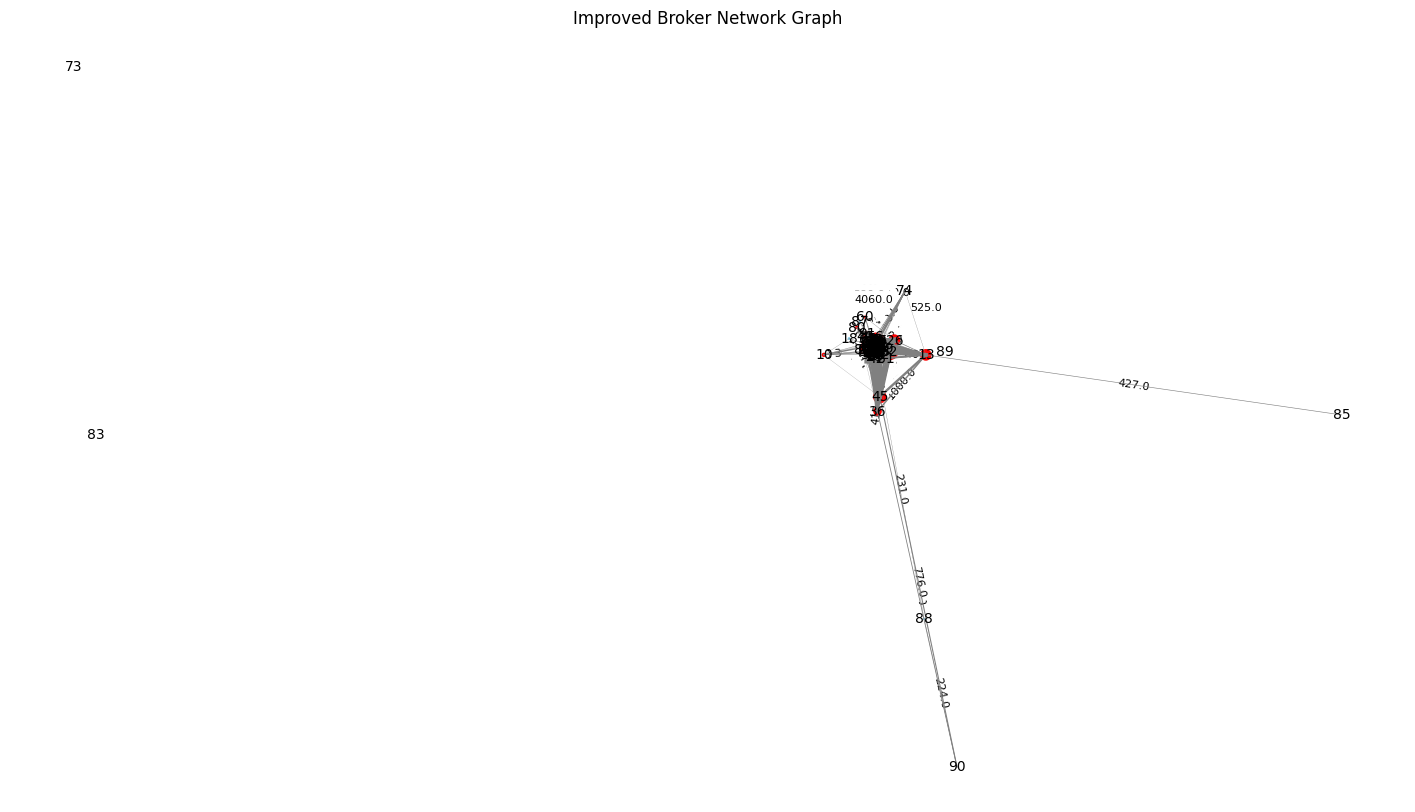

In [ ]:

import networkx as nx
import random
# ... (your build_graph function remains the same) ...



# Build graph from DataFrame
node_features_dict, edge_dict = build_graph(df)

# Create a directed graph using networkx
G = nx.DiGraph()

# Add nodes and their attributes
for broker, features in node_features_dict.items():
    G.add_node(broker, features=features)

# Add edges and their attributes (weights)
for (buyer, seller), edge_features in edge_dict.items():
    G.add_edge(buyer, seller, weight=edge_features['qty_sum'])

# Visualize the graph
pos = nx.spring_layout(G, k=0.15, seed=42)  # Adjust k for spacing

# Create a larger figure
plt.figure(figsize=(18, 10))

# Draw nodes (color by manipulator status, size by buy_vol)
node_colors = ['red' if G.nodes[node]['features'][6] else 'skyblue' for node in G.nodes()]
node_sizes = [G.nodes[node]['features'][0] / 500 for node in G.nodes()]  # Scale node size

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors)

# Draw edges (filter by weight)
edge_labels = {}
for u, v, data in G.edges(data=True):
    if data['weight'] > 100:  # Adjust threshold
        plt.plot([pos[u][0], pos[v][0]], [pos[u][1], pos[v][1]], color='gray', linewidth=data['weight'] / 1000)
        edge_labels[(u, v)] = data['weight']

# Draw edge labels (filter and reduce size)
filtered_edge_labels = {k: v for k, v in edge_labels.items() if v > 200}  # Adjust threshold
nx.draw_networkx_edge_labels(G, pos, edge_labels=filtered_edge_labels, font_size=8)

# Draw node labels
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

plt.title("Improved Broker Network Graph")
plt.axis('off')
plt.show()

In [ ]:
!pip install plotly

In [ ]:

#import numpy as np
import pandas as pd
import networkx as nx
import community as community_louvain # install with: pip install python-louvain
import matplotlib.pyplot as plt

# ... (your build_graph function remains the same) ...

# Load data from CSV file (with data type specification)
df = pd.read_csv('ABM.csv', low_memory=False) # Add dtype where required.

# Build graph from DataFrame
node_features_dict, edge_dict = build_graph(df)

# Create a directed graph using networkx
G = nx.DiGraph()

# Add nodes and their attributes
for broker, features in node_features_dict.items():
    G.add_node(broker, features=features)

# Add edges and their attributes (weights)
for (buyer, seller), edge_features in edge_dict.items():
    G.add_edge(buyer, seller, weight=edge_features['qty_sum'])

# Convert to undirected graph for community detection
undirected_G = G.to_undirected()

# Community detection
partition = community_louvain.best_partition(undirected_G) # Ensure python-louvain is installed correctly

# Visualize communities
pos = nx.spring_layout(undirected_G, seed=42)
plt.figure(figsize=(12, 10))
plt.axis('off')
nx.draw_networkx_nodes(undirected_G, pos, node_size=600, cmap=plt.cm.RdYlBu, node_color=list(partition.values()))
nx.draw_networkx_edges(undirected_G, pos, alpha=0.5)
nx.draw_networkx_labels(undirected_G, pos)
plt.show()

AttributeError: module 'community' has no attribute 'best_partition'

In [77]:
!pip uninstall python-louvain -y
!pip install python-louvain

Found existing installation: python-louvain 0.16
Uninstalling python-louvain-0.16:
  Successfully uninstalled python-louvain-0.16
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.6/204.6 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for python-louvain: filename=python_louvain-0.16-py3-none-any.whl size=9388 sha256=70a65b1c846adf3adc696a5dea31b26dfe8da12e150f5b54519454c156790181
  Stored in directory: /root/.cache/pip/wheels/11/c1/e7/f62a211c636275e2da798bf0c307a3ae79aeddaf2524a03ce4
Successfully built python-louvain


In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import community as community_louvain
import matplotlib.pyplot as plt

# Copy and paste the build_graph function here:
def build_graph(df):
    """
    Build a directed graph representation from the entire dataset.
    Returns:
        node_features_dict: { broker_id: [buy_vol, sell_vol, net_vol, avg_rate, total_trades, volatility, is_manipulator] }
        edge_dict: { (buyer, seller): { 'qty_sum': ..., 'count': ..., 'avg_rate': ... } }
    """
    nodes = {}
    edges = {}

    # Ensure that the quantity and rate columns are numeric
    df['Qty.'] = pd.to_numeric(df['Qty.'], errors='coerce')
    df['Rate'] = pd.to_numeric(df['Rate'], errors='coerce')

    # Defining manipulators based on updated conditions
    buy_volume_threshold = df['Qty.'].quantile(0.95)  # Top 5% buy volume is considered significant
    sell_volume_threshold = df['Qty.'].quantile(0.05)  # Bottom 5% sell volume is considered significant

    for _, row in df.iterrows():
        buyer = row['Buyer']
        seller = row['Seller']
        qty = row['Qty.']
        rate = row['Rate']

        # Skip rows with NaN values in qty or rate
        if pd.isna(qty) or pd.isna(rate):
            continue

        # Update buyer node
        if buyer not in nodes:
            nodes[buyer] = {
                'buy_vol': 0, 'sell_vol': 0, 'rates': [], 'is_manipulator': False
            }
        nodes[buyer]['buy_vol'] += qty
        nodes[buyer]['rates'].append(rate)

        # Update seller node
        if seller not in nodes:
            nodes[seller] = {
                'buy_vol': 0, 'sell_vol': 0, 'rates': [], 'is_manipulator': False
            }
        nodes[seller]['sell_vol'] += qty
        nodes[seller]['rates'].append(rate)

        # Update edge (buyer -> seller)
        edge_key = (buyer, seller)
        if edge_key not in edges:
            edges[edge_key] = {
                'qty_sum': 0,  # total shares traded
                'count': 0,    # number of transactions
                'rate_sum': 0, # sum of rates to compute average
            }
        edges[edge_key]['qty_sum'] += qty
        edges[edge_key]['count'] += 1
        edges[edge_key]['rate_sum'] += rate

    # Build node feature dictionary
    node_features_dict = {}
    for broker, info in nodes.items():
        buy_vol = info['buy_vol']
        sell_vol = info['sell_vol']
        net_vol = buy_vol - sell_vol
        avg_rate = np.mean(info['rates']) if info['rates'] else 0
        total_trades = len(info['rates'])  # how many times this broker participated
        volatility = np.std(info['rates']) if len(info['rates']) > 1 else 0
        is_manipulator = False

        # Identify manipulators based on the conditions provided
        if buy_vol >= buy_volume_threshold:
            is_manipulator = True
        elif sell_vol <= sell_volume_threshold and sell_vol > 0:
            is_manipulator = True

        node_features_dict[broker] = [
            buy_vol,
            sell_vol,
            net_vol,
            avg_rate,
            total_trades,
            volatility,
            is_manipulator
        ]

    # Update edge attributes (like average rate)
    for key, info in edges.items():
        edges[key]['avg_rate'] = info['rate_sum'] / info['count'] if info['count'] > 0 else 0

    return node_features_dict, edges
# Load data from CSV file
file_path = 'ABM.csv'
df = pd.read_csv('ABM.csv')

# Build graph from DataFrame
node_features_dict, edge_dict = build_graph(df)

# Create a directed graph using networkx
G = nx.DiGraph()

# ... (rest of your code) ...

#Print python-louvain version
print(community_louvain.__version__)

0.16


In [2]:
import community as community_louvain

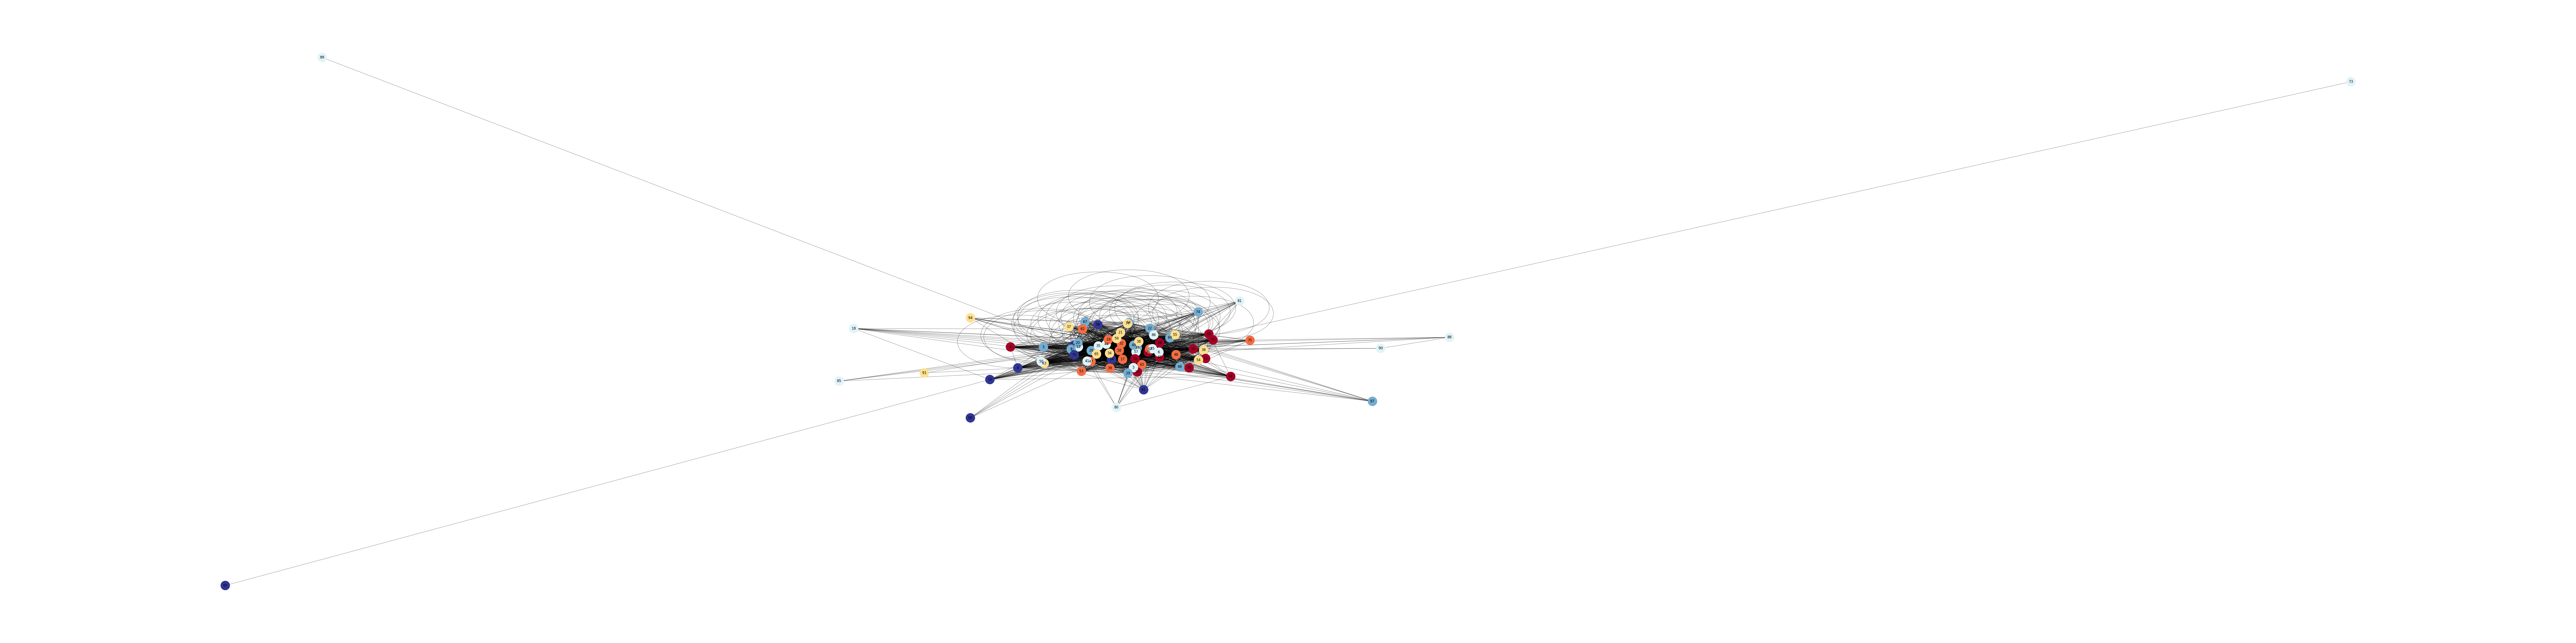

0.16


In [3]:
import numpy as np
import pandas as pd
import networkx as nx
import community as community_louvain
import matplotlib.pyplot as plt
# Build graph from DataFrame
node_features_dict, edge_dict = build_graph(df)

# Create a directed graph using networkx
G = nx.DiGraph()

# Add nodes and their attributes
for broker, features in node_features_dict.items():
    G.add_node(broker, features=features)

# Add edges and their attributes (weights)
for (buyer, seller), edge_features in edge_dict.items():
    G.add_edge(buyer, seller, weight=edge_features['qty_sum'])

# Convert to undirected graph for community detection
undirected_G = G.to_undirected()

# Community detection
partition = community_louvain.best_partition(undirected_G)

# Visualize communities
pos = nx.spring_layout(undirected_G, seed=42)
plt.figure(figsize=(160, 40))
plt.axis('off')
nx.draw_networkx_nodes(undirected_G, pos, node_size=1000, cmap=plt.cm.RdYlBu, node_color=list(partition.values()))
nx.draw_networkx_edges(undirected_G, pos, alpha=0.5)
nx.draw_networkx_labels(undirected_G, pos)
plt.show() #Click on the zoom to preview more detailed one

#Print python-louvain version
print(community_louvain.__version__)

In [ ]:
!pip install python-igraph louvain-igraph

ERROR: Could not find a version that satisfies the requirement louvain-igraph (from versions: none)
ERROR: No matching distribution found for louvain-igraph


In [5]:
print(f"Number of nodes: {len(undirected_G.nodes())}")
print(f"Number of edges: {len(undirected_G.edges())}")

Number of nodes: 79
Number of edges: 1791


In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import plotly.graph_objects as go

def build_graph(df):
    """
    Build a directed graph representation from the entire dataset.
    Returns:
        node_features_dict: { broker_id: [buy_vol, sell_vol, net_vol, avg_rate, total_trades, volatility, is_manipulator] }
        edge_dict: { (buyer, seller): { 'qty_sum': ..., 'count': ..., 'avg_rate': ... } }
    """
    nodes = {}
    edges = {}

    # Ensure that the quantity and rate columns are numeric
    df['Qty.'] = pd.to_numeric(df['Qty.'], errors='coerce')
    df['Rate'] = pd.to_numeric(df['Rate'], errors='coerce')

    # Defining manipulators based on updated conditions
    buy_volume_threshold = df['Qty.'].quantile(0.95)  # Top 5% buy volume is considered significant
    sell_volume_threshold = df['Qty.'].quantile(0.05)  # Bottom 5% sell volume is considered significant

    for _, row in df.iterrows():
        buyer = row['Buyer']
        seller = row['Seller']
        qty = row['Qty.']
        rate = row['Rate']

        # Skip rows with NaN values in qty or rate
        if pd.isna(qty) or pd.isna(rate):
            continue

        # Update buyer node
        if buyer not in nodes:
            nodes[buyer] = {
                'buy_vol': 0, 'sell_vol': 0, 'rates': [], 'is_manipulator': False
            }
        nodes[buyer]['buy_vol'] += qty
        nodes[buyer]['rates'].append(rate)

        # Update seller node
        if seller not in nodes:
            nodes[seller] = {
                'buy_vol': 0, 'sell_vol': 0, 'rates': [], 'is_manipulator': False
            }
        nodes[seller]['sell_vol'] += qty
        nodes[seller]['rates'].append(rate)

        # Update edge (buyer -> seller)
        edge_key = (buyer, seller)
        if edge_key not in edges:
            edges[edge_key] = {
                'qty_sum': 0,  # total shares traded
                'count': 0,    # number of transactions
                'rate_sum': 0, # sum of rates to compute average
            }
        edges[edge_key]['qty_sum'] += qty
        edges[edge_key]['count'] += 1
        edges[edge_key]['rate_sum'] += rate

    # Build node feature dictionary
    node_features_dict = {}
    for broker, info in nodes.items():
        buy_vol = info['buy_vol']
        sell_vol = info['sell_vol']
        net_vol = buy_vol - sell_vol
        avg_rate = np.mean(info['rates']) if info['rates'] else 0
        total_trades = len(info['rates'])  # how many times this broker participated
        volatility = np.std(info['rates']) if len(info['rates']) > 1 else 0
        is_manipulator = False

        # Identify manipulators based on the conditions provided
        if buy_vol >= buy_volume_threshold:
            is_manipulator = True
        elif sell_vol <= sell_volume_threshold and sell_vol > 0:
            is_manipulator = True

        node_features_dict[broker] = [
            buy_vol,
            sell_vol,
            net_vol,
            avg_rate,
            total_trades,
            volatility,
            is_manipulator
        ]

    # Update edge attributes (like average rate)
    for key, info in edges.items():
        edges[key]['avg_rate'] = info['rate_sum'] / info['count'] if info['count'] > 0 else 0

    return node_features_dict, edges

# Load data from CSV file
file_path = 'ABM.csv'  # Use the filename directly as it's uploaded to the current directory
df = pd.read_csv(file_path)

# Build graph from DataFrame
node_features_dict, edge_dict = build_graph(df)
print(node_features_dict)
print(edge_dict)
# Load data from CSV file
file_path = 'ABM.csv'
df = pd.read_csv(file_path)

# Build graph from DataFrame
node_features_dict, edge_dict = build_graph(df)

# Create a directed graph using networkx
G = nx.DiGraph()

# Add nodes and their attributes
for broker, features in node_features_dict.items():
    G.add_node(broker, features=features)

# Add edges and their attributes (weights)
for (buyer, seller), edge_features in edge_dict.items():
    G.add_edge(buyer, seller, weight=edge_features['qty_sum'])

# Calculate Volatility, Strength, and Averages
if 'Timestamp' in df.columns:
    try:
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])
        volatility = df.groupby('Buyer')['Qty.'].std().fillna(0)
        broker_averages = df.groupby('Buyer')['Qty.'].mean().fillna(0)
    except Exception as e:
        print(f"Error processing Timestamp column: {e}")
        volatility = pd.Series([0] * len(G.nodes()), index=G.nodes())
        broker_averages = pd.Series([0] * len(G.nodes()), index=G.nodes())
else:
    print("Timestamp column not found. Skipping time-series calculations.")
    volatility = pd.Series([0] * len(G.nodes()), index=G.nodes())
    broker_averages = pd.Series([0] * len(G.nodes()), index=G.nodes())

# 3D Layout
pos = nx.spring_layout(G, dim=3, seed=42)

# Node positions
node_x = [pos[v][0] for v in G.nodes()]
node_y = [pos[v][1] for v in G.nodes()]
node_z = [pos[v][2] for v in G.nodes()]

# Edge positions
edge_x = []
edge_y = []
edge_z = []
edge_weights = []
for u, v, data in G.edges(data=True):
    edge_x.extend([pos[u][0], pos[v][0], None])
    edge_y.extend([pos[u][1], pos[v][1], None])
    edge_z.extend([pos[u][2], pos[v][2], None])
    edge_weights.append(data['weight'])

# Node traces
node_trace = go.Scatter3d(
    x=node_x, y=node_y, z=node_z,
    mode='markers',
    marker=dict(size=10, color=[volatility[node] for node in G.nodes()], colorscale='Viridis'),
    text=[f"Broker: {node}<br>Avg: {broker_averages[node]:.2f}<br>Volatility: {volatility[node]:.2f}" for node in G.nodes()]
)

# Edge traces
if edge_weights:  # Check if there are edges
    avg_edge_weight = sum(edge_weights) / len(edge_weights)
    edge_trace = go.Scatter3d(
        x=edge_x, y=edge_y, z=edge_z,
        mode='lines',
        line=dict(width=avg_edge_weight / max(edge_weights) * 3 if max(edge_weights) else 1, color='gray')  # Use average weight
    )
else:
    edge_trace = go.Scatter3d(x=[], y=[], z=[], mode='lines', line=dict(width=1, color='gray')) #if there is no edges, then render an empty graph

# Layout
layout = go.Layout(
    title='Interactive 3D Broker Network Graph',
    showlegend=False,
    scene=dict(
        xaxis=dict(title='X'),
        yaxis=dict(title='Y'),
        zaxis=dict(title='Z')
    )
)

# Figure
fig = go.Figure(data=[edge_trace, node_trace], layout=layout)
fig.show()

if 'Date' in df.columns:
    try:
        df['Date'] = pd.to_datetime(df['Date'])
        volatility = df.groupby('Buyer')['Qty.'].std().fillna(0)
        broker_averages = df.groupby('Buyer')['Qty.'].mean().fillna(0)
    except Exception as e:
        print(f"Error processing Date column: {e}")
        volatility = pd.Series([0] * len(G.nodes()), index=G.nodes())
        broker_averages = pd.Series([0] * len(G.nodes()), index=G.nodes())
else:
    print("Date column not found. Skipping time-series calculations.")
    volatility = pd.Series([0] * len(G.nodes()), index=G.nodes())
    broker_averages = pd.Series([0] * len(G.nodes()), index=G.nodes())

# Print Volatility and Broker Averages
print("Volatility Index:")
print(volatility)
print("\nBroker Averages:")
print(broker_averages)

{33: [166349.0, 176973.0, -10624.0, np.float64(581.1835589941973), 2585, np.float64(189.478603020026), True], 46: [93616.0, 106814.0, -13198.0, np.float64(661.8167061611375), 1688, np.float64(207.48003091385252), True], 39: [328950.0, 233210.0, 95740.0, np.float64(650.3858940237117), 4133, np.float64(182.6350873697293), True], 36: [192218.0, 188787.0, 3431.0, np.float64(687.9092814371259), 3173, np.float64(191.58975587944596), True], 57: [355496.0, 420683.0, -65187.0, np.float64(697.3063661202185), 7320, np.float64(187.1326042376425), True], 49: [383620.0, 422053.0, -38433.0, np.float64(672.5761894363314), 7327, np.float64(192.30853525315658), True], 14: [188324.0, 205755.0, -17431.0, np.float64(660.6423248882265), 3355, np.float64(199.27068171987716), True], 71: [486882.0, 375744.0, 111138.0, np.float64(585.7883653416703), 4478, np.float64(171.30038026159073), True], 34: [446237.0, 448826.0, -2589.0, np.float64(668.724582181866), 7599, np.float64(193.82941800219578), True], 25: [19083

Volatility Index:
Buyer
1      136.363771
3      146.632140
4      108.692947
5      114.123594
6      125.437281
          ...    
96     188.630875
97     267.868953
98      76.039676
99     130.928838
101    200.196941
Name: Qty., Length: 90, dtype: float64

Broker Averages:
Buyer
1       97.371790
3      115.132758
4       80.268812
5       82.943735
6       82.104343
          ...    
96     154.377850
97     175.500000
98      69.331754
99     106.427419
101    153.703125
Name: Qty., Length: 90, dtype: float64


# New Section